--- Barrier Knock-Out Option Pricing ---
Monte Carlo Call Estimate: 1.3916 (StdDev: 3.4896)
Knocked Out Paths: 3884 / 10000 (38.84%)


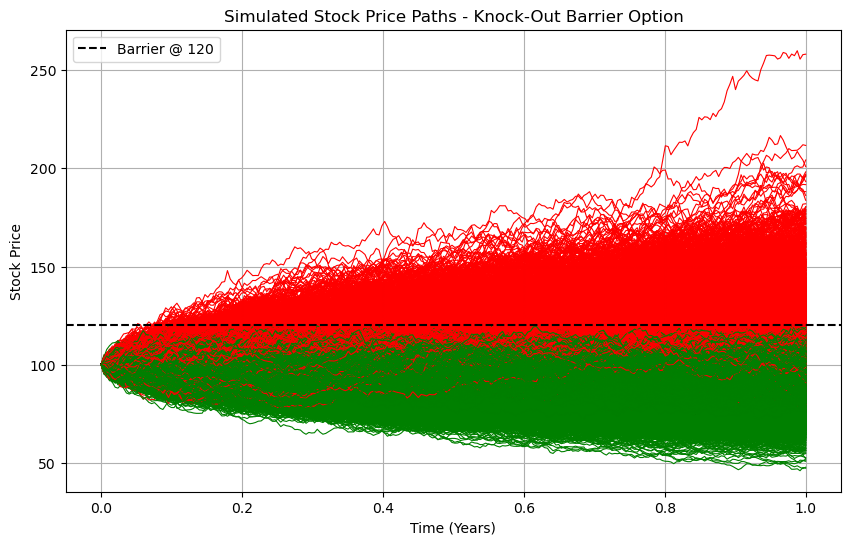

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100       # Initial stock price
K = 100        # Strike price
T = 1.0        # Time to maturity (in years)
r = 0.05       # Risk-free rate
sigma = 0.2    # Volatility
barrier = 120  # Barrier level for knock-out
n_simulations = 10000
n_steps = 252
option_type = "call"  # or "put"

# Monte Carlo Simulation for Knock-Out Barrier Option
dt = T / n_steps
np.random.seed(42)
Z = np.random.standard_normal((n_simulations, n_steps))
S = np.zeros_like(Z)
S[:, 0] = S0

for t in range(1, n_steps):
    S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * math.sqrt(dt) * Z[:, t])

# Knock-out condition: path must not cross the barrier
knocked_out = (S >= barrier).any(axis=1)

# Payoffs
S_T = S[:, -1]
payoffs = np.zeros(n_simulations)

if option_type == "call":
    payoffs[~knocked_out] = np.maximum(S_T[~knocked_out] - K, 0)
else:
    payoffs[~knocked_out] = np.maximum(K - S_T[~knocked_out], 0)

payoffs_discounted = np.exp(-r * T) * payoffs
mc_price = np.mean(payoffs_discounted)
mc_std = np.std(payoffs_discounted)

print("--- Barrier Knock-Out Option Pricing ---")
print(f"Monte Carlo {option_type.capitalize()} Estimate: {mc_price:.4f} (StdDev: {mc_std:.4f})")
print(f"Knocked Out Paths: {(knocked_out.sum())} / {n_simulations} ({knocked_out.mean()*100:.2f}%)")

# Plot sample paths with barrier
plt.figure(figsize=(10, 6))
for i in range(n_simulations):
    plt.plot(np.linspace(0, T, n_steps), S[i], lw=0.8,
             color='red' if knocked_out[i] else 'green')
plt.axhline(barrier, color='black', linestyle='--', label=f'Barrier @ {barrier}')
plt.title("Simulated Stock Price Paths - Knock-Out Barrier Option")
plt.xlabel("Time (Years)")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()





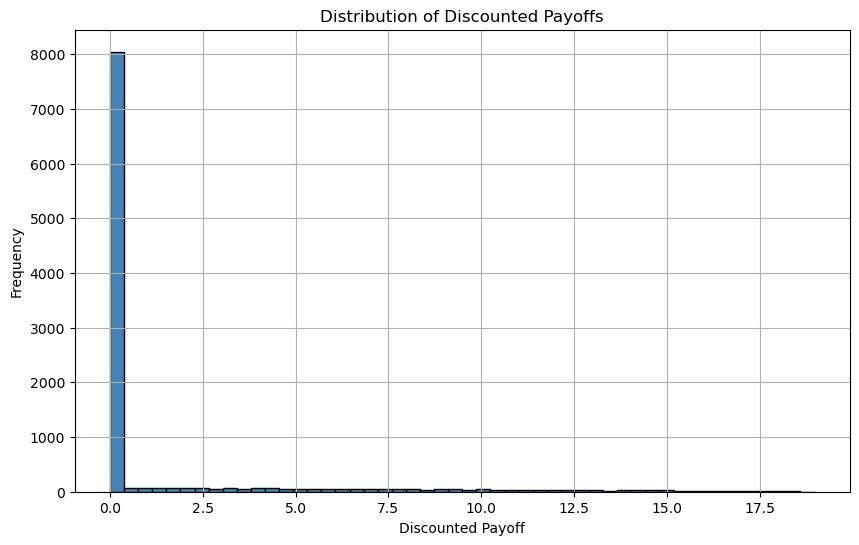

In [5]:
# Discounted Payoffs distribution
plt.figure(figsize=(10, 6))
plt.hist(payoffs_discounted, bins=50, color='steelblue', edgecolor='black')
plt.title("Distribution of Discounted Payoffs")
plt.xlabel("Discounted Payoff")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [18]:
# Test 20 distribution fits

import pandas as pd
import warnings

distributions = [
    "norm", "expon", "lognorm", "gamma", "beta", "uniform", "triang",
    "weibull_min", "weibull_max", "pareto", "t", "laplace", "cauchy",
    "logistic", "gumbel_r", "gumbel_l", "rayleigh", "wald", "chi2", "invgauss"
]

results = []

for dist_name in distributions:
    dist = getattr(stats, dist_name)
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            params = dist.fit(payoffs_discounted)
            D, p = stats.kstest(payoffs_discounted, dist_name, args=params)
        results.append((dist_name, D, p, params))
    except Exception:
        results.append((dist_name, np.nan, 0, None))

df_results = pd.DataFrame(results, columns=["Distribution", "KS_statistic", "p_value", "Params"])
df_results = df_results.sort_values("KS_statistic").reset_index(drop=True)

print(df_results[["Distribution", "KS_statistic", "p_value"]])



   Distribution  KS_statistic  p_value
0      logistic      0.399821      0.0
1      gumbel_l      0.404246      0.0
2          norm      0.452572      0.0
3             t      0.479731      0.0
4       lognorm      0.490380      0.0
5       laplace      0.500000      0.0
6      gumbel_r      0.501521      0.0
7   weibull_max      0.508437      0.0
8      rayleigh      0.533995      0.0
9          wald      0.639417      0.0
10       cauchy      0.649310      0.0
11     invgauss      0.743317      0.0
12       triang      0.792576      0.0
13         beta      0.797476      0.0
14  weibull_min      0.797596      0.0
15       pareto      0.797600      0.0
16      uniform      0.797600      0.0
17        gamma      0.797600      0.0
18        expon      0.797600      0.0
19         chi2      0.797600      0.0


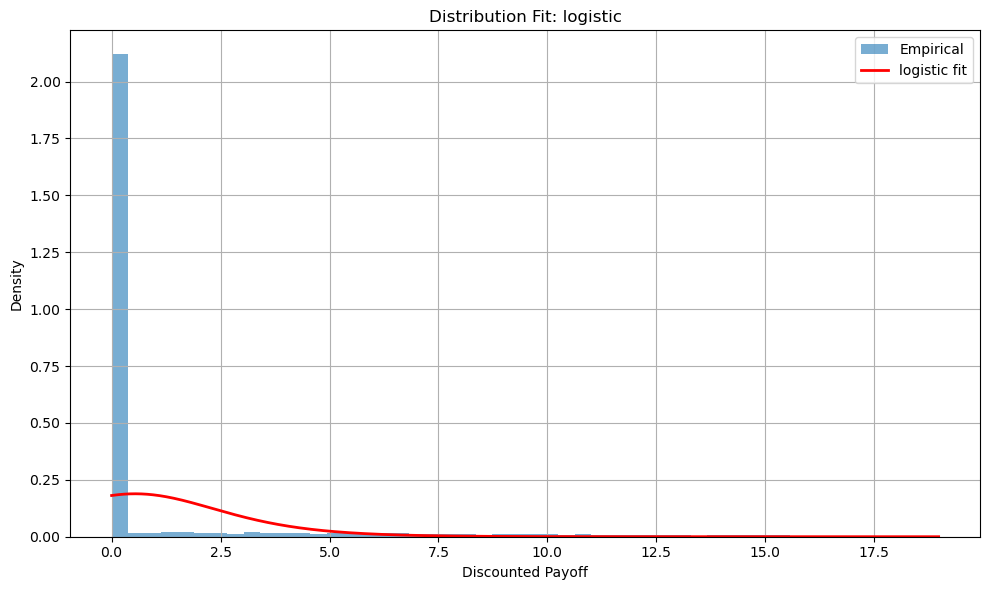

In [19]:
# Plot histogram + best fitting distribution
best_dist_name = df_results.loc[0, "Distribution"]
best_params = df_results.loc[0, "Params"]
best_dist = getattr(stats, best_dist_name)

x = np.linspace(min(payoffs_discounted), max(payoffs_discounted), 1000)
pdf = best_dist.pdf(x, *best_params)

plt.figure(figsize=(10, 6))
plt.hist(payoffs_discounted, bins=50, density=True, alpha=0.6, label="Empirical")
plt.plot(x, pdf, 'r-', lw=2, label=f"{best_dist_name} fit")
plt.title(f"Distribution Fit: {best_dist_name}")
plt.xlabel("Discounted Payoff")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()